In [1]:
import numpy as np
import math
import scipy
from scipy import linalg
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator
from mod2 import mod10_to_mod2 as dec2bin

Create functions required for defining Hamiltonian State Transfer on Python.

In [2]:
#n-qubit statevector emulator
def ket2state_vec(ket):
    
    #basis states
    zero=np.array([1,0])
    one=np.array([0,1]) 
    
    #loop through ket
    
    if ket[0]==0: temp=zero
    elif ket[0]==1: temp=one
    
    for i,_ in enumerate(ket):
        
        if i == len(ket)-1: break
            
        if ket[i+1]==0: temp2=zero
        elif ket[i+1]==1: temp2=one
    
        temp=np.kron(temp,temp2)
        
    return temp

# Pauli matrices
p_x = np.array([[0.,  1.], [1.,  0.]])
p_y = np.array([[0., -1j], [1j,  0.]])
p_z = np.array([[1.,  0.], [0., -1.]])
I = np.identity(2)

def k_kron(*args):
    """
    The standard Python kron function takes only 2 inputs at a time by default, so we define another function that 
    takes in arbitrary inputs.
    """
    ret = np.array([1])
    for q in args:
        ret = np.kron(ret, q)
    return ret

Create a function for state transfer over spin chain of length n=2, based on Hamiltonian for the Heisenberg XY model.  To correct for phases, a sum of Pauli $Z$ terms are also added.

In [3]:
def exchangeH(n, B=0.5):
    
    def J(k,n):
        return (1/2)*math.sqrt((k+1)*(n-(k+1)))

    h=np.zeros((2**n,2**n)).astype("complex128")

    for k in range(n-1):
        kron_list=[I]*n       
        kron_list[k]=p_x 
        kron_list[k+1]=p_x 

        h+=J(k,n)*k_kron(*kron_list)

    for k in range(n-1):
        kron_list=[I]*n       
        kron_list[k]=p_y
        kron_list[k+1]=p_y

        h+=J(k,n)*k_kron(*kron_list)
       
    for k in range(n):
        kron_list=[I]*n
        kron_list[k]= p_z 

        h+=B*k_kron(*kron_list)      

#found through trial and error that coupling strength of B=0.5 fixes phase shifts in state transfer over 2 qubits.
        
    return(h/2)

Define time evolution over grid of 3 spin chains.

In [7]:
h=exchangeH(2)

def timeev(h,t):
    tempU = linalg.expm(-1j*h*t)
    return k_kron(tempU,tempU,tempU)

def U(t):
    return timeev(h,t)

Functions for generating initial and target superposition states for state transfer.

In [5]:
def fidelity(S,evS):
    fidelity= abs(np.conjugate(S.T)@evS)
    return fidelity

def normalise(vec): 
    norm=np.sqrt(np.conjugate(vec).T@vec)
    return vec/norm
#function for creating  superposition states
def superposition_state(a,b):
  psi=a*ket2state_vec([0])+b*ket2state_vec([1])
  return normalise(psi)

a=np.random.random()+1j*np.random.random() 
b=np.random.random()+1j*np.random.random()
psi=superposition_state(a,b)

n=2 #spin chain length
temp = ket2state_vec([0]*(n-1)) # |000...>

#intial spin chain state (psi on left)
def initial(psi):
    st1=np.kron(psi,temp)
    return k_kron(st1, st1, st1) # initial= |psi>|0...> \otimes |psi>|0...>

#final spin chain state (psi on right)
def target(psi):
    st2=np.kron(temp, psi)
    return k_kron(st2, st2, st2)  # target= |0...>|psi> \otimes |0...>|psi> 

psi, initial(psi), target(psi), target(psi).shape

(array([0.2300454 +0.18380806j, 0.53652581+0.79084371j]),
 array([-0.01114232+0.02297183j,  0.        +0.j        ,
        -0.05661371+0.0605063j ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
        -0.05661371+0.0605063j , -0.        +0.j        ,
        -0.23363979+0.13317144j, -0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
        -0.056

Text(0.5, 1.0, 'State Transfer over grid of 3 chains (length n=2, XY+gZ with g=0,5).')

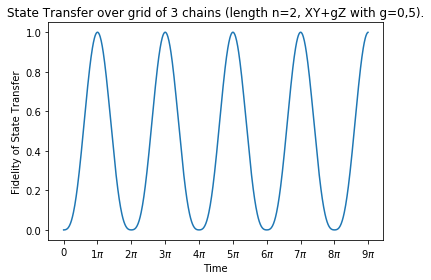

In [6]:
timeS=(math.pi)*np.arange(0,9,0.01)

f_list=[]

for t in timeS:
    evS=U(t)@initial(psi)
    # print(U(t))
    f=fidelity(target(psi),evS)
    f_list.append(f)
    
f, ax=plt.subplots(1)
    
plt.plot(timeS, f_list)
ax.xaxis.set_major_formatter(FuncFormatter(
   lambda val,pos: '{:.0g}$\pi$'.format(val/np.pi) if val !=0 else '0'
))
ax.xaxis.set_major_locator(MultipleLocator(base=np.pi))
plt.xlabel("Time")
plt.ylabel("Fidelity of State Transfer")
plt.title('State Transfer over grid of 3 chains (length n=2, XY+gZ with g=0,5).')